<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/facenet_finetune_final9631.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face detection and recognition training pipeline

The following example illustrates how to fine-tune an InceptionResnetV1 model on your own dataset. This will mostly follow standard pytorch training patterns.

In [1]:
!nvidia-smi

Sat Aug 22 14:52:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install https://download.pytorch.org/whl/cu92/torchvision-0.6.0%2Bcu92-cp36-cp36m-linux_x86_64.whl
!pip install https://download.pytorch.org/whl/cu92/torch-1.5.0%2Bcu92-cp36-cp36m-linux_x86_64.whl


     |████████████████████████████████| 6.5MB 1.7MB/s 
     |████████████████████████████████| 752.0MB 24kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
     |████████████████████████████████| 603.7MB 31kB/s 
  Found existing installation: torch 1.5.0
    Uninstalling torch-1.5.0:
      Successfully uninstalled torch-1.5.0


In [4]:
!pip install git+https://github.com/timesler/facenet-pytorch.git

  Cloning https://github.com/timesler/facenet-pytorch.git to /tmp/pip-req-build-emmrcb5x
  Running command git clone -q https://github.com/timesler/facenet-pytorch.git /tmp/pip-req-build-emmrcb5x
  Running command git submodule update --init --recursive -q
  Created wheel for facenet-pytorch: filename=facenet_pytorch-2.3.1-cp36-none-any.whl size=1881485 sha256=3028ccef503c5b852a849f06f0ef3228af957d621f170fad3013025eb0a62e78
  Stored in directory: /tmp/pip-ephem-wheel-cache-7z09l28a/wheels/bb/7f/6e/cb1c4c2a68f2a037ecd1b5d6de22b05d36a4852ad4e36e439d
Successfully built facenet-pytorch


In [5]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR,StepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os

In [6]:
torch.__version__

'1.5.0+cu92'

In [52]:
!git clone https://github.com/timesler/facenet-pytorch.git

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 1181 (delta 16), reused 10 (delta 2), pack-reused 1143
Receiving objects: 100% (1181/1181), 22.61 MiB | 31.41 MiB/s, done.
Resolving deltas: 100% (566/566), done.


#### Define run parameters

The dataset should follow the VGGFace2/ImageNet-style directory layout. Modify `data_dir` to the location of the dataset on wish to finetune on.

In [ ]:
!rm -rf /content/S4_cropped

In [7]:
!cp /content/drive/My\ Drive/EVA4/P2S4/S4_data.zip /content

In [8]:
!unzip -q /content/S4_data.zip

In [9]:
!ls -lart /content/S4/

total 40
drwxr-xr-x  2 root root 4096 Aug 17 22:15  GustavMahler
drwxr-xr-x  2 root root 4096 Aug 17 22:28 'New folder (2)'
drwxr-xr-x  2 root root 4096 Aug 19 21:44  RichFroning
drwxr-xr-x  2 root root 4096 Aug 19 22:38  Tia
drwxr-xr-x  2 root root 4096 Aug 19 22:41  JimMorrison
drwxr-xr-x 10 root root 4096 Aug 19 22:41  .
drwxr-xr-x  2 root root 4096 Aug 19 22:46  ARR
drwxr-xr-x  2 root root 4096 Aug 19 22:47  JanisJoplin
drwxr-xr-x  2 root root 4096 Aug 19 22:52  DavidGoggins
drwxr-xr-x  1 root root 4096 Aug 22 14:59  ..


In [10]:
!rm -rf '/content/S4/New folder (2)'

In [11]:
data_dir = '/content/S4'

batch_size = 32
epochs = 30
workers = 0 if os.name == 'nt' else 8

#### Determine if an nvidia GPU is available

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

See `help(MTCNN)` for more details.

In [13]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [14]:
!rm -rf /content/S4/.ipynb_checkpoints

#### Perfom MTCNN facial detection

Iterate through the DataLoader object and obtained cropped faces.

In [ ]:
!rm -rf /content/S4_cropped

In [15]:
data_dir='/content/S4'
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]
        
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

dataset.class_to_idx

{'ARR': 0,
 'DavidGoggins': 1,
 'GustavMahler': 2,
 'JanisJoplin': 3,
 'JimMorrison': 4,
 'RichFroning': 5,
 'Tia': 6}

In [16]:
for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

Batch 5 of 5

In [17]:
class_names = list(dataset.class_to_idx.keys())
class_names

['ARR',
 'DavidGoggins',
 'GustavMahler',
 'JanisJoplin',
 'JimMorrison',
 'RichFroning',
 'Tia']

In [ ]:
for val in glob.glob('/content/S4_cropped/*'):
    for icount,fileval in enumerate(glob.glob(val+'/*')):
        base_file_name=os.path.basename(fileval)
        extn = base_file_name.split(".")[-1]
        new_file= os.path.join(val, os.path.basename(val)+str(icount)+"."+extn)
        os.rename(fileval,new_file)
        #print(new_file)

In [ ]:
glob.glob('/content/S4_cropped/*/*')

#### Define Inception Resnet V1 module

See `help(InceptionResnetV1)` for more details.

In [18]:
resnet_classifier = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

In [19]:
import torch.nn as nn

In [20]:
class ModelParamFreezer():
    def freeze_layer(self, param_list):
        params_list = sum(param_list,[])
        for param in params_list:
            #print("Setting False")
            param.requires_grad = False

    def get_core_layer_count(self):
        return len(self.core_layer_params)

    def get_core_layer_params(self):
        return sum(self.core_layer_params,[])
    
    def get_all_param_names(self):
        return sum(self.core_layer_params,[])

    def unfreeze_core_layer(self, n_lower_layer):
        if(n_lower_layer > self.get_core_layer_count()):
            print("Request to unfreeze {} layers, core layer has {} layers".format(n_lower_layer, self.get_core_layer_count))
            return None
        param_list = sum(self.core_layer_params[-n_lower_layer:],[])
        for param in param_list:
            param.requires_grad = True
        return sum(self.core_layer_params[-n_lower_layer:],self.classifier_params)
    
    def __init__(self, model, freeze=True,classifier_layer_count=0):
        self.param_list = list(model.children())
        self.core_layer_param_names = [[param[0] for param in child.named_parameters()] for child in self.param_list]

        self.classifier_params = []
        if(classifier_layer_count >  0):
            self.param_list = list(model.children())[:-classifier_layer_count]
            self.classifier_params = sum([ [param[1] for param in child.named_parameters()] for child in list(model.children())[-classifier_layer_count:]],[])
          
        self.core_layer_params = [[param[1] for param in child.named_parameters()] for child in self.param_list]
        if(freeze == True):
            self.freeze_layer(self.core_layer_params)
        




In [21]:
param_handler = ModelParamFreezer(resnet_classifier, classifier_layer_count=5)

In [22]:
grad_params = param_handler.unfreeze_core_layer(1)
#grad_params = resnet_classifier.parameters()

In [ ]:
!cp /content/resnet_custom_facedetect_2.pt /content/drive/My\ Drive/EVA4/baseline_models

In [ ]:
!cp /content/drive/My\ Drive/EVA4/lfw-funneled.tgz /content/

In [ ]:
!tar -zxvf lfw-funneled.tgz

In [ ]:
glob.glob()

#### Define optimizer, scheduler, dataset, and dataloader

In [23]:
#optimizer = optim.Adam(resnet.parameters(), lr=0.001)
#grad_params=resnet_classifier.parameters()
np.random.seed(seed=1001)
#data_dir='/content/lfw_funneled'
#data_dir='/content/S4'
optimizer = optim.SGD(grad_params, lr=0.001,momentum=0.85)

#scheduler = MultiStepLR(optimizer, [5, 10])
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)
#dataset = datasets.ImageFolder(data_dir , transform=trans)
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.8 * len(img_inds))]
val_inds = img_inds[int(0.8 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)
class_names = list(dataset.class_to_idx.keys())
# resnet_classifier = InceptionResnetV1(
#     classify=True,
#     pretrained='vggface2',
#     num_classes=len(dataset.class_to_idx)
# ).to(device)

In [24]:
class_names

['ARR',
 'DavidGoggins',
 'GustavMahler',
 'JanisJoplin',
 'JimMorrison',
 'RichFroning',
 'Tia']

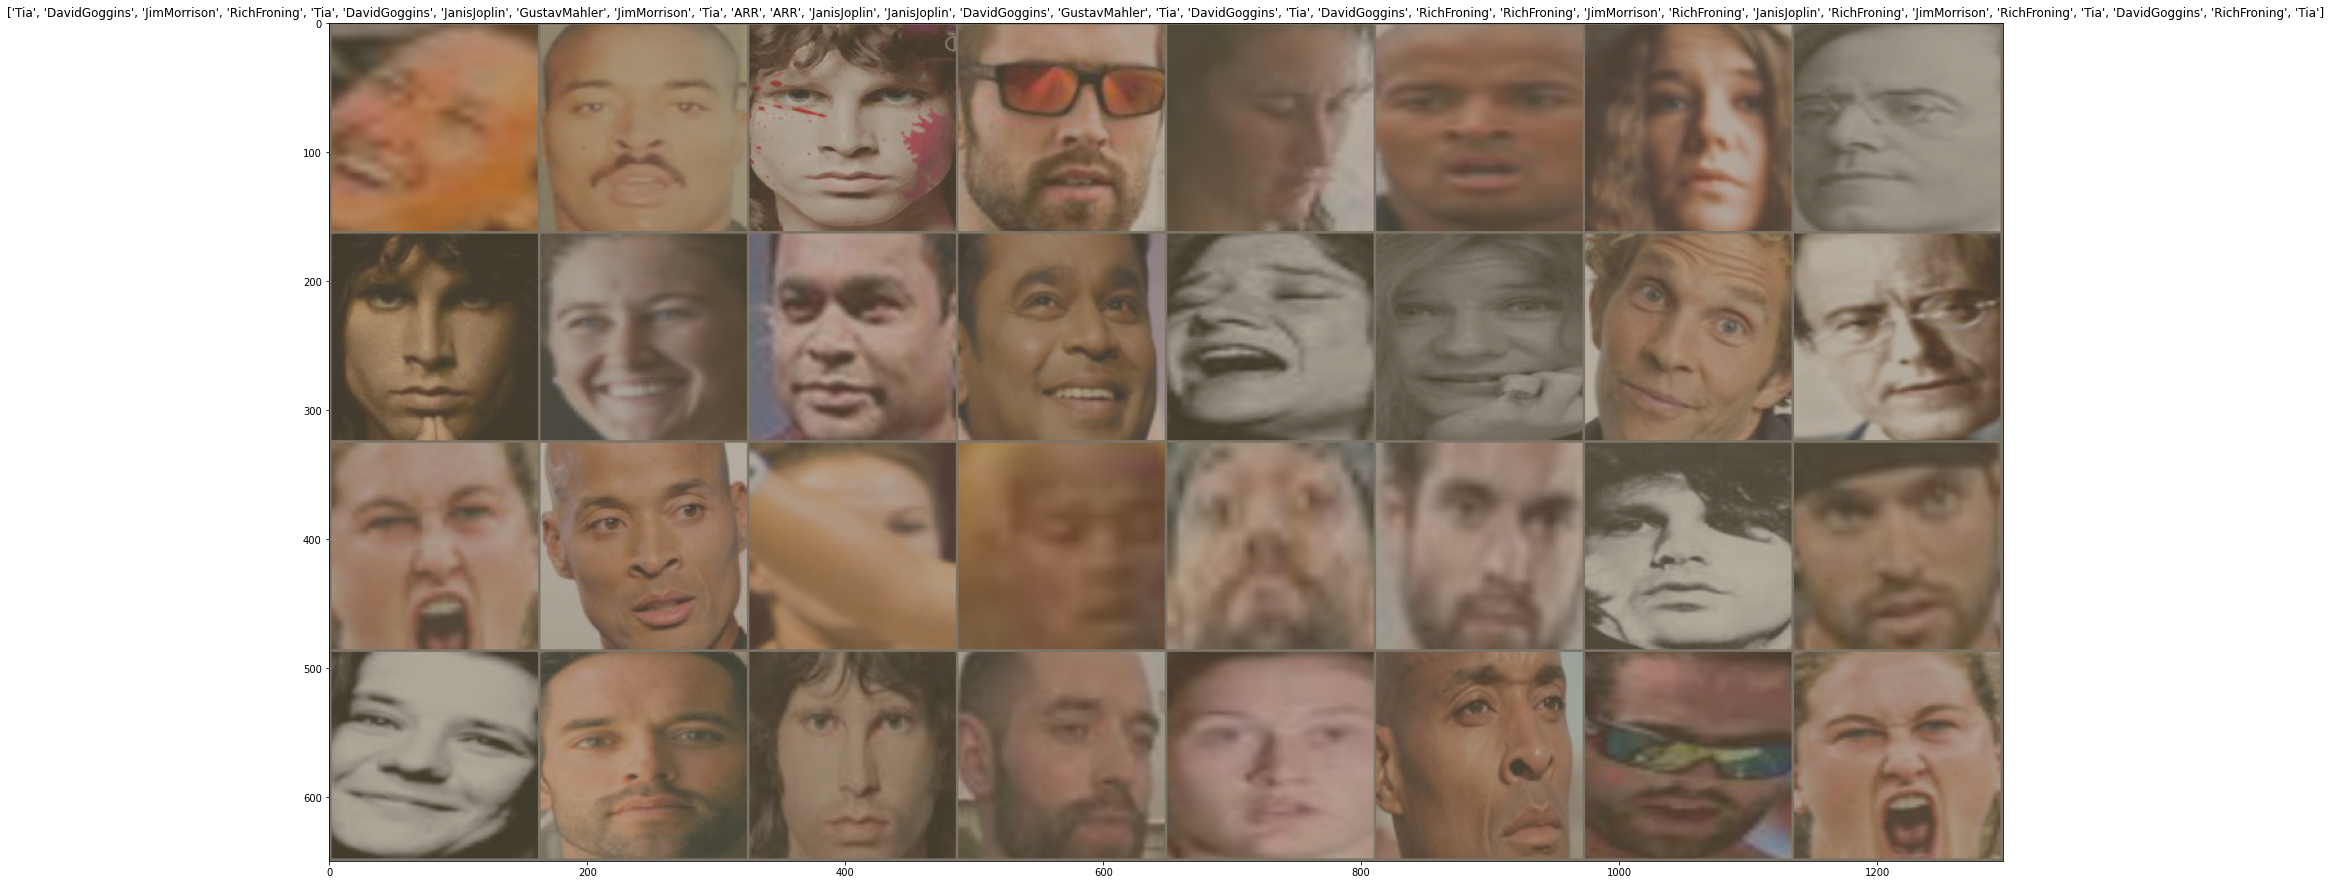

In [25]:
from torchvision import transforms, utils, datasets, models
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,30))
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_loader))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

#### Define loss and evaluation functions

In [26]:
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

#### Train model

In [27]:
dataloaders= {'train':train_loader, 'val':val_loader}
dataset_sizes={'val':len(val_inds), 'train':len(train_inds)}   #{'train':train_loader, 'val':val_loader}

In [29]:
import time,copy
def train_model(model, criterion, optimizer, scheduler,
                num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()
                
                FT_losses.append(loss.item())
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() /dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

### Layer 1 unfrozen

In [30]:
model_ft, FT_losses = train_model(resnet_classifier, loss_fn, optimizer, scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 2.0151 Acc: 0.1200
val Loss: 1.6339 Acc: 0.3846
Epoch 1/29
----------
train Loss: 1.5998 Acc: 0.4600
val Loss: 1.2978 Acc: 0.6154
Epoch 2/29
----------
train Loss: 1.3432 Acc: 0.6400
val Loss: 1.2633 Acc: 0.6923
Epoch 3/29
----------
train Loss: 1.3088 Acc: 0.6400
val Loss: 1.2340 Acc: 0.7308
Epoch 4/29
----------
train Loss: 1.2638 Acc: 0.6700
val Loss: 1.2219 Acc: 0.8077
Epoch 5/29
----------
train Loss: 1.2792 Acc: 0.6700
val Loss: 1.2428 Acc: 0.7308
Epoch 6/29
----------
train Loss: 1.2925 Acc: 0.7100
val Loss: 1.2242 Acc: 0.8077
Epoch 7/29
----------
train Loss: 1.3184 Acc: 0.6600
val Loss: 1.2262 Acc: 0.8462
Epoch 8/29
----------
train Loss: 1.2388 Acc: 0.7100
val Loss: 1.2178 Acc: 0.8462
Epoch 9/29
----------
train Loss: 1.2931 Acc: 0.6600
val Loss: 1.2232 Acc: 0.8462
Epoch 10/29
----------
train Loss: 1.2532 Acc: 0.7100
val Loss: 1.2303 Acc: 0.8462
Epoch 11/29
----------
train Loss: 1.2615 Acc: 0.6800
val Loss: 1.2193 Acc: 0.8462
Epoch 12/29
--

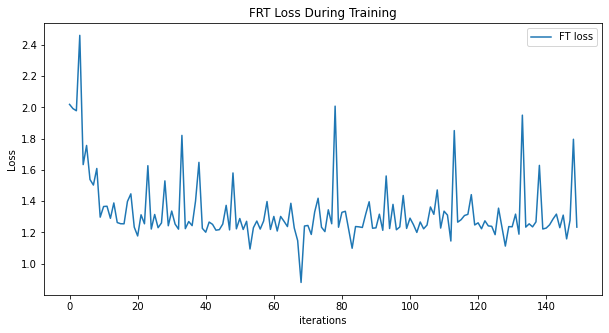

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [38]:
grad_params = param_handler.unfreeze_core_layer(1)
optimizer = optim.SGD(grad_params, lr=0.001,momentum=0.85)

#scheduler = MultiStepLR(optimizer, [5, 10])
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [39]:
model_ft, FT_losses = train_model(resnet_classifier.to(device), loss_fn, optimizer, scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 1.2390 Acc: 0.7100
val Loss: 1.0628 Acc: 0.8462
Epoch 1/29
----------
train Loss: 1.0883 Acc: 0.8000
val Loss: 0.8846 Acc: 0.8846
Epoch 2/29
----------
train Loss: 0.9340 Acc: 0.8500
val Loss: 0.8580 Acc: 0.8846
Epoch 3/29
----------
train Loss: 0.9042 Acc: 0.8500
val Loss: 0.8494 Acc: 0.8846
Epoch 4/29
----------
train Loss: 0.8977 Acc: 0.8900
val Loss: 0.8391 Acc: 0.9231
Epoch 5/29
----------
train Loss: 0.8746 Acc: 0.8900
val Loss: 0.8361 Acc: 0.9231
Epoch 6/29
----------
train Loss: 0.8849 Acc: 0.8700
val Loss: 0.8583 Acc: 0.8846
Epoch 7/29
----------
train Loss: 0.8778 Acc: 0.8400
val Loss: 0.8667 Acc: 0.9231
Epoch 8/29
----------
train Loss: 0.8749 Acc: 0.8700
val Loss: 0.8446 Acc: 0.9231
Epoch 9/29
----------
train Loss: 0.8693 Acc: 0.9200
val Loss: 0.8413 Acc: 0.9231
Epoch 10/29
----------
train Loss: 0.8864 Acc: 0.8700
val Loss: 0.8503 Acc: 0.9231
Epoch 11/29
----------
train Loss: 0.8856 Acc: 0.8800
val Loss: 0.8434 Acc: 0.9231
Epoch 12/29
--

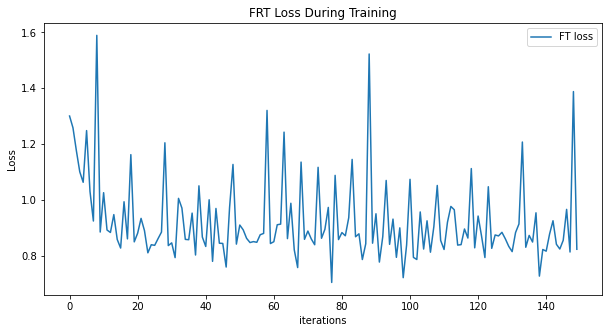

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [42]:
grad_params = param_handler.unfreeze_core_layer(2)
optimizer = optim.SGD(grad_params, lr=0.001,momentum=0.85)

#scheduler = MultiStepLR(optimizer, [5, 10])
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [43]:
model_ft, FT_losses = train_model(resnet_classifier.to(device), loss_fn, optimizer, scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.8775 Acc: 0.8800
val Loss: 0.7432 Acc: 0.9231
Epoch 1/29
----------
train Loss: 0.7409 Acc: 0.9400
val Loss: 0.6437 Acc: 0.9231
Epoch 2/29
----------
train Loss: 0.6634 Acc: 0.9400
val Loss: 0.6219 Acc: 0.9231
Epoch 3/29
----------
train Loss: 0.6294 Acc: 0.9400
val Loss: 0.6179 Acc: 0.9615
Epoch 4/29
----------
train Loss: 0.6328 Acc: 0.9400
val Loss: 0.6111 Acc: 0.9615
Epoch 5/29
----------
train Loss: 0.6215 Acc: 0.9200
val Loss: 0.6134 Acc: 0.9231
Epoch 6/29
----------
train Loss: 0.6479 Acc: 0.9200
val Loss: 0.6147 Acc: 0.9615
Epoch 7/29
----------
train Loss: 0.6246 Acc: 0.9200
val Loss: 0.6170 Acc: 0.9615
Epoch 8/29
----------
train Loss: 0.6357 Acc: 0.9200
val Loss: 0.6246 Acc: 0.9615
Epoch 9/29
----------
train Loss: 0.6128 Acc: 0.9500
val Loss: 0.6375 Acc: 0.9615
Epoch 10/29
----------
train Loss: 0.6313 Acc: 0.9200
val Loss: 0.6441 Acc: 0.9615
Epoch 11/29
----------
train Loss: 0.6406 Acc: 0.9300
val Loss: 0.6214 Acc: 0.9615
Epoch 12/29
--

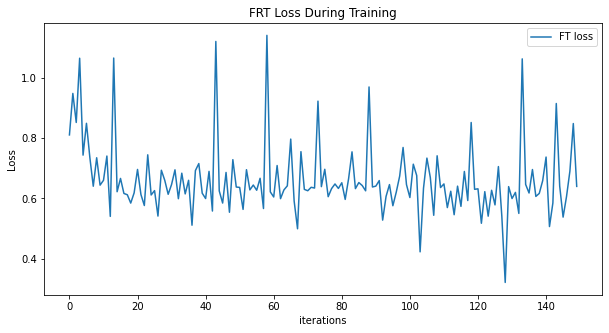

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [46]:
torch.save({
    'model_state_dict': model_ft.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, '/content/resnet_custom_facedetect_9631.pt')

In [ ]:
%run '/content/drive/My Drive/EVA4/default_setup.py'

In [45]:
traced_model = torch.jit.trace(model_ft.to("cpu"), torch.randn(1,3,160,160))
torch.jit.save(traced_model, '/content/resnet_custom_facedetect_2.pt')
#awsutils.upload_model_to_s3('rekog-eva4s1','/content/CustomMobileNetV2_8889.pt',os.path.basename('/content/CustomMobileNetV2_8889.pt'))

In [51]:
from RekogNizer import awsutils

awsutils.upload_model_to_s3('rekog-eva4s1','/content/resnet_custom_facedetect_2.pt',os.path.basename('/content/resnet_custom_facedetect_2.pt'))

In [72]:
from PIL import Image 
transformed_img = trans(img=Image.open('/content/S4_cropped/ARR/ARRAHMAN2.jpg'))



AttributeError: ignored

In [48]:
resnet_classifier.to(device)(transformed_img.unsqueeze(0).to(device)).argmax().item()

0

In [49]:
!cp /content/resnet_custom_facedetect_9631.pt /content/drive/My\ Drive/EVA4/baseline_models/

In [95]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device='cpu'
)
img = np.array(Image.open('/content/S4/GustavMahler/36703f3508a76cf5ba95a260621952e5_XL.jpg').convert('RGB'))
face_tensor, prob = mtcnn(img, save_path='face.png', return_prob=True)

In [96]:
face_tensor.numpy(),prob

(array([[[-0.26953125, -0.20703125, -0.17578125, ..., -0.58203125,
          -0.57421875, -0.55859375],
         [-0.11328125, -0.04296875, -0.04296875, ..., -0.65234375,
          -0.65234375, -0.64453125],
         [ 0.04296875,  0.05078125,  0.06640625, ..., -0.66015625,
          -0.67578125, -0.65234375],
         ...,
         [ 0.90234375,  0.94140625,  0.93359375, ...,  0.49609375,
           0.51953125,  0.55859375],
         [ 0.91015625,  0.94921875,  0.94921875, ...,  0.51171875,
           0.48828125,  0.51953125],
         [ 0.90234375,  0.96484375,  0.96484375, ...,  0.51171875,
           0.51171875,  0.52734375]],
 
        [[-0.26953125, -0.20703125, -0.17578125, ..., -0.58203125,
          -0.57421875, -0.55859375],
         [-0.11328125, -0.04296875, -0.04296875, ..., -0.65234375,
          -0.65234375, -0.64453125],
         [ 0.04296875,  0.05078125,  0.06640625, ..., -0.66015625,
          -0.67578125, -0.65234375],
         ...,
         [ 0.90234375,  0.9414062

In [ ]:
transformations_local = transforms.Compose([
    fixed_image_standardization
])
transformations_local(face_tensor)

In [98]:
model_ft(face_tensor.unsqueeze(0).to(device)).argmax().item()

2

In [79]:
class_names

['ARR',
 'DavidGoggins',
 'GustavMahler',
 'JanisJoplin',
 'JimMorrison',
 'RichFroning',
 'Tia']